In [1]:
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
if tf.config.list_physical_devices('GPU'):
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    batch_size = 128
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)
else:
    print('The model will run on a CPU')
    batch_size = 64

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


In [3]:
n_classes = 10

data_path = 'imagenet10'

train_data_folder = data_path + '/' + 'train/'
val_data_folder = data_path + '/' + 'val/'

train_images_numbers = 12394
val_images_numbers = 1000

img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=0.2,
        brightness_range=[0.7, 1.3],
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=0.2,
                                  brightness_range=[0.7, 1.3],
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
        train_data_folder,
        target_size=(img_width, img_height),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        val_data_folder,
        target_size=(img_width, img_height),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical')

Found 12394 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

In [6]:
x = base_model.output
output = Dense(n_classes, activation='softmax', dtype='float32')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.summary()

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [8]:
he_normal = tf.keras.initializers.he_normal()

In [9]:
for layer in model.layers:
    if layer.name.endswith('_bn'):
      new_weights = [
          he_normal(layer.weights[0].shape),
          tf.zeros(layer.weights[1].shape),
          tf.zeros(layer.weights[2].shape),
          tf.ones(layer.weights[3].shape)]

      layer.set_weights(new_weights)
      layer.trainable = True
    else:
      layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
callbacks = [
    EarlyStopping(patience=20, monitor='val_accuracy', mode="auto"),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, monitor='val_accuracy', mode='max', verbose=1),
    ModelCheckpoint('imagenet10.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

In [12]:
results = model.fit(train_generator,
          steps_per_epoch=train_images_numbers // batch_size,
          validation_data=test_generator,
          validation_steps=val_images_numbers // batch_size,
          epochs=500,
          callbacks=callbacks)

Epoch 1/500
96/96 [==============================] - 78s 695ms/step - loss: 1.8552 - accuracy: 0.3321 - val_loss: 2.3787 - val_accuracy: 0.0971

Epoch 00001: val_accuracy improved from -inf to 0.09710, saving model to drive/MyDrive/imagenet10.h5
Epoch 2/500
96/96 [==============================] - 64s 666ms/step - loss: 1.2288 - accuracy: 0.5825 - val_loss: 2.4261 - val_accuracy: 0.0993

Epoch 00002: val_accuracy improved from 0.09710 to 0.09933, saving model to drive/MyDrive/imagenet10.h5
Epoch 3/500
96/96 [==============================] - 64s 665ms/step - loss: 1.0203 - accuracy: 0.6614 - val_loss: 2.5864 - val_accuracy: 0.1004

Epoch 00003: val_accuracy improved from 0.09933 to 0.10045, saving model to drive/MyDrive/imagenet10.h5
Epoch 4/500
96/96 [==============================] - 64s 666ms/step - loss: 0.9276 - accuracy: 0.7010 - val_loss: 2.4443 - val_accuracy: 0.0938

Epoch 00004: val_accuracy did not improve from 0.10045
Epoch 5/500
96/96 [==============================] - 64s

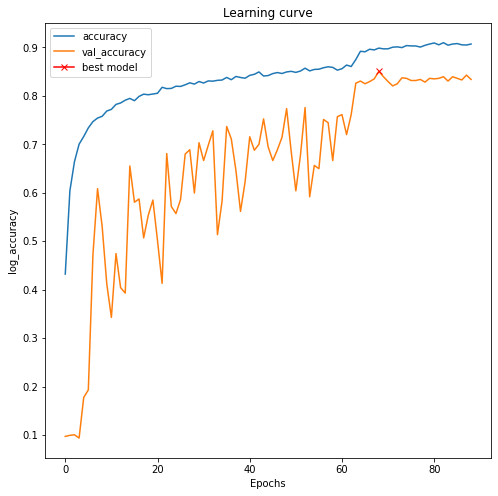

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();

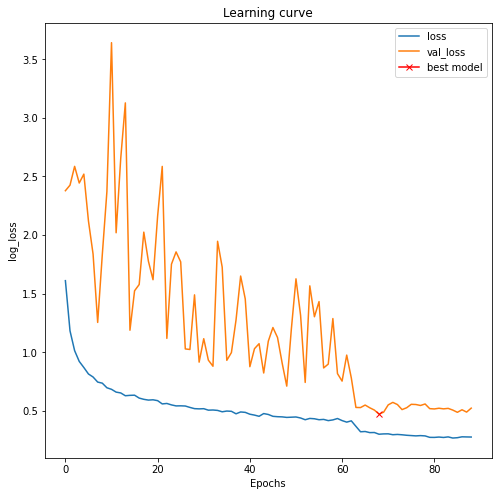

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();